In [1]:
from qiskit import *
import numpy as np, matplotlib.pyplot as plt
from qiskit.tools.monitor import *
from qiskit.tools.visualization import plot_distribution

plt.style.use(['science', 'notebook', 'grid', 'dark_background'])

Grover's Algorithm can serve as a **quantum search algorithm** to find a marked item in an unsorted list, and runs on a quantum computer. It finds the unique input to a blackbox function that produces a particular output value, using just $O(\sqrt N)$ evaluations of the function, where $N$ is the size of the list.

It doesn't utilize the list's internal structure, and is therefore not useful for searching a sorted list. It is also not useful for searching a list of size N=2^n, as the list can be searched in O$(logN)$ time using a classical computer.

In [2]:
my_list = np.random.randint(0, 100, 100)
my_list

array([88, 87, 72, 14, 38, 53,  5,  8, 65, 16, 95, 51, 94, 44, 62, 14, 86,
       53, 44, 94, 79, 33, 31, 45,  0,  4, 31, 44, 51, 98, 32, 59, 76, 29,
       24, 91, 87,  5, 78, 48, 13, 57, 57, 88, 87, 78, 96, 54, 50, 20, 19,
        4, 99, 14, 57, 29, 95, 99, 43, 71, 52, 33, 16, 67, 30, 52, 59, 82,
       42, 68, 59, 73, 66, 81, 41, 99, 95, 16, 43, 98, 87, 79, 96, 26, 70,
       95, 52, 26, 99, 99, 36, 78, 21, 46, 22,  8, 84, 67, 26,  3])

Our goal is to locate a **random number** that you can choose and implement in  my code, that'll be present in this list. The Search Function ```oracle``` will do this for us:

In [3]:
def oracle(input):
    winner = 53 # CHANGE THIS AS YOU PLEASE
    
    if input == winner:
        return True
    else:
        return False

for index, trialnumber in enumerate(my_list):
    if oracle(trialnumber) == 1:
        print(f"Winner found at index {index} with value {trialnumber}")
        print(f"Total number of oracle trials: {index + 1}")
        
        break

Winner found at index 5 with value 53
Total number of oracle trials: 6


Defining the Oracle Quantum circuit:

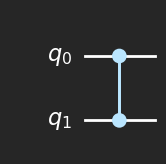

In [4]:
oracle_circuit = QuantumCircuit(2, name = 'Oracle')
oracle_circuit.cz(0, 1)
oracle_circuit.to_gate()

oracle_circuit.draw(output = 'mpl', style = 'iqx-dark')

And now the actual Grover's Circuit:

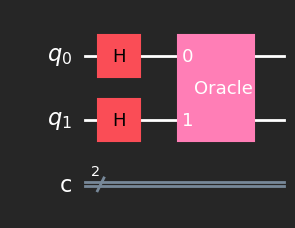

In [5]:
backend = Aer.get_backend('statevector_simulator')
grover = QuantumCircuit(2, 2)
grover.h([0, 1])
grover.append(oracle_circuit, [0, 1])

grover.draw(output = 'mpl', style = 'iqx-dark')

In [6]:
job = execute(grover, backend)
sv = job.result().get_statevector()
np.round(sv, 3)

array([ 0.5+0.j,  0.5+0.j,  0.5+0.j, -0.5+0.j])

We can create a *Reflection Circuit* to amplify the amplitude of the marked state, and then apply the Grover's Circuit to the Oracle to get the final Grover's Circuit:

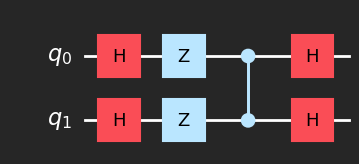

In [7]:
reflection = QuantumCircuit(2, name = 'Reflection')
reflection.h([0, 1])
reflection.z([0, 1])
reflection.cz(0, 1)
reflection.h([0, 1])
reflection.to_gate()

reflection.draw(output = 'mpl', style = 'iqx-dark')

Appending the Reflection Circuit to the Grover's Circuit:

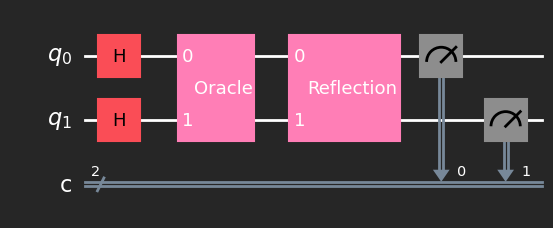

In [8]:
grover.append(reflection, [0, 1])
grover.measure([0, 1], [0, 1])

grover.draw(output = 'mpl', style = 'iqx-dark')

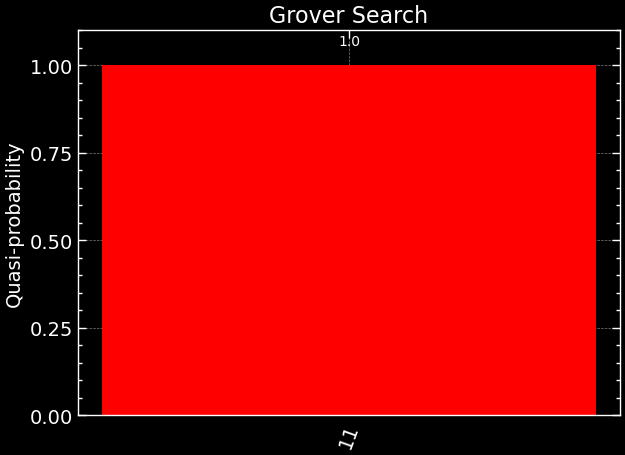

In [9]:
job = execute(grover, backend, shots = 1)
counts = job.result().get_counts()

plot_distribution(counts, title = 'Grover Search', color = 'red')

This visualization represents te **frequency of states** after each Grover's Iteration. The marked state will have a higher probability of being measured after each iteration, and the probability of measuring the marked state will increase with each iteration.

We now implement Grover's Algorithm on a real IBM Quantum Computer:

In [11]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub = 'ibm-q')

We only used {'11': 1024} calls to the oracle to find the winner! Here, |11> is the winner state.


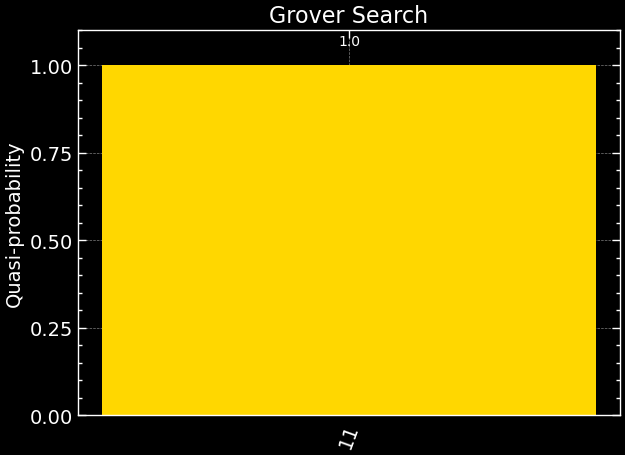

In [12]:
backend_qasm = provider.get_backend('ibmq_qasm_simulator')
job = execute(grover, backend_qasm, shots = 1024)
counts = job.result().get_counts()

print(f'We only used {counts} calls to the oracle to find the winner! Here, |11> is the winner state.')
plot_distribution(counts, title = 'Grover Search', color = 'gold')